<a href="https://colab.research.google.com/github/Arunabh13prt/Music-Genre-Classification-and-Recommendation-System/blob/main/Genre_Classification_and_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Genre Classification and Recommendation System**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 130, 13, 32)       320       
                                                                 
 batch_normalization_18 (Ba  (None, 130, 13, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 65, 7, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 65, 7, 32)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 65, 7, 64)         18

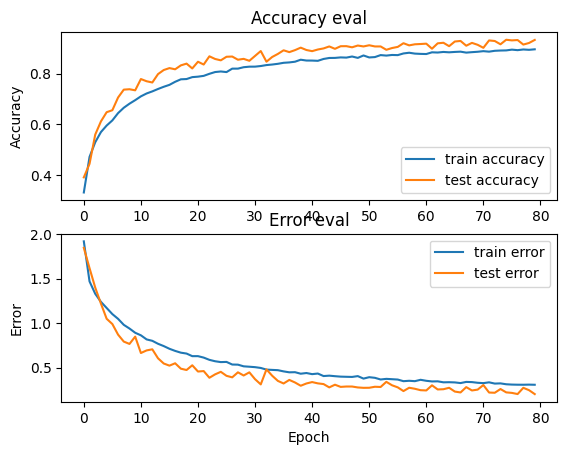

235/235 - 1s - loss: 0.2199 - accuracy: 0.9280 - 914ms/epoch - 4ms/step

Test accuracy: 0.9280374050140381
1/1 [==============================] - 0s 143ms/step
Predicted genre: metal
1/1 [==============================] - 0s 118ms/step
Recommended songs:
Path: /content/drive/My Drive/InternshipDatasets/GTZAN/genres_original/metal/metal.00051.wav, Similarity: 0.8453


Path: /content/drive/My Drive/InternshipDatasets/GTZAN/genres_original/metal/metal.00055.wav, Similarity: 0.8322


Path: /content/drive/My Drive/InternshipDatasets/GTZAN/genres_original/metal/metal.00046.wav, Similarity: 0.8296


Path: /content/drive/My Drive/InternshipDatasets/GTZAN/genres_original/metal/metal.00052.wav, Similarity: 0.8287


Path: /content/drive/My Drive/InternshipDatasets/GTZAN/genres_original/metal/metal.00053.wav, Similarity: 0.8266


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import json
import numpy as np
import librosa
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import Audio, display

# Genre names
GENRE_DICT = {
    0: "blues",
    1: "hiphop",
    2: "disco",
    3: "rock",
    4: "jazz",
    5: "reggae",
    6: "metal",
    7: "classical",
    8: "pop",
    9: "country"
}

# Loading Data from the JSON file
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    paths = np.array(data["paths"])
    return X, y, paths

# Function for Visual Representation
def plot_history(history):
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    plt.show()

# Preparation of the Processed dataset
def prepare_datasets(test_size, validation_size, data_path):
    X, y, paths = load_data(data_path)
    X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(X, y, paths, test_size=test_size)
    X_train, X_validation, y_train, y_validation, paths_train, paths_validation = train_test_split(X_train, y_train, paths_train, test_size=validation_size)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    return X_train, X_validation, X_test, y_train, y_validation, y_test, paths_train, paths_validation, paths_test

# Model
def build_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.4))

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
    model.add(keras.layers.Dropout(0.4))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

# Genre Prediction function
def predict(model, X, y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    predicted_genre = GENRE_DICT[predicted_index[0]]
    print("Target: {}, Predicted label: {}, Predicted genre: {}".format(y, predicted_index, predicted_genre))

# MFCC extraction from the audio given by user as input
def extract_mfcc(file_path, n_mfcc=13, n_fft=2048, hop_length=512, fixed_length=130):
    signal, sample_rate = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T

    if len(mfcc) > fixed_length:
        mfcc = mfcc[:fixed_length]
    elif len(mfcc) < fixed_length:
        padding = fixed_length - len(mfcc)
        mfcc = np.pad(mfcc, ((0, padding), (0, 0)), mode='constant')

    return mfcc

def prepare_input(file_path, fixed_length=130):
    mfcc = extract_mfcc(file_path, fixed_length=fixed_length)
    mfcc = mfcc[np.newaxis, ..., np.newaxis]
    return mfcc

def extract_embeddings(model, X):
    embedding_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    embeddings = embedding_model.predict(X)
    return embeddings

# Recommending function
def recommend_songs(embeddings, paths, input_embedding, top_n=5):
    similarities = cosine_similarity(input_embedding, embeddings)
    similar_indices = np.argsort(similarities[0])[::-1][1:top_n+1]
    return [(paths[idx], similarities[0][idx]) for idx in similar_indices]

if __name__ == "__main__":
    DATA_PATH = "/content/drive/My Drive/file_name.json"
    file_path = "/content/drive/My Drive/audio.wav"

    X_train, X_validation, X_test, y_train, y_validation, y_test, paths_train, paths_validation, paths_test = prepare_datasets(0.25, 0.2, DATA_PATH)

    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=80, batch_size=32, callbacks=[early_stopping])

    plot_history(history)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"\nTest accuracy: {test_acc}")

    # Prediction
    X_new = prepare_input(file_path)
    prediction = model.predict(X_new)
    predicted_index = np.argmax(prediction, axis=1)
    predicted_genre = GENRE_DICT[predicted_index[0]]
    print("Predicted genre:", predicted_genre)

    # Extract embeddings and recommend songs
    embeddings = extract_embeddings(model, X_test)
    input_embedding = extract_embeddings(model, X_new)
    recommendations = recommend_songs(embeddings, paths_test, input_embedding)

    print("Recommended songs:")
    for path, similarity in recommendations:
        print(f"Path: {path}, Similarity: {similarity:.4f}")
        display(Audio(path))
